In [2]:
import warnings
warnings.filterwarnings("ignore")
import os
import time
import joblib
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from ast import literal_eval
import seaborn as sns
import gc
import sklearn
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import ClassifierChain
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models as gensimvis
from IPython.core.display import display, HTML

In [3]:
#pip install --upgrade gensim

In [4]:
#pip install pyldavis

In [5]:
data = pd.read_csv("data_cleaned.csv", sep=',',
                   converters={"Title": literal_eval,
                               "Body": literal_eval,
                               "Tags": literal_eval})

In [6]:
data.head()

,Title,Body,Score,Tags
0,"[pyqt, dialog, thread]","[program, window, window, thread, power, photo...",2,"[python, multithreading]"
1,"[action, cable, angularjs, cross, domain, inte...","[rail, application, backend, core, rail, appli...",5,"[ruby-on-rails, angularjs]"
2,"[mockito, mock, exit, method]","[method, mockito, mock, test, mock, statement,...",1,"[python, unit-testing]"
3,"[integrating, spring, cloud, application, aws,...","[intent, poc, aws, parameter, store, property,...",2,[java]
4,"[custom, header, swagger, response]","[webapi, server, swagger, endpoint, content, s...",3,"[c#, .net]"


Nous allons également créer une variable Full_doc qui accueillera le document complet de chaque item (Title et Body) :

In [7]:
#data["Full_doc"] = data.apply(lambda x: list(eval(x.Title))+list(eval(x.Body)), axis=1)
data["Full_doc"] = data["Title"] + data["Body"]
data["Full_doc"].head(3)

0    [pyqt, dialog, thread, program, window, window...
1    [action, cable, angularjs, cross, domain, inte...
2    [mockito, mock, exit, method, method, mockito,...
Name: Full_doc, dtype: object

# Preprocessing : Bag of Words / Tf-Idf

Pour alimenter les modèles de machine learning, nous avons besoin de traiter des données numériques. Le modèle Bag of Words apprend un vocabulaire à partir de tous les documents, puis modélise chaque document en comptant le nombre de fois où chaque mot apparaît, convertissant donc les données textuelles en données numériques.

Nos données ayant déjà été cleanées et tokenisées , nous allons initialiser l'algorithme du CountVectorizer sur les variables Title et Body (X1 et X2) sans preprocessing. Enfin, nous allons utiliser le module TfidfVectorizer de la librairie Scikit-Learn pour combiner le CountVectorizer et TfidfTransformer. Cela aura pour effet de pondérer la fréquence d'apparition des mots par un indicateur de similarité (si ce mot est commun ou rare dans tous les documents). Dans cette partie, nous allons éliminer les mots qui apparaissent dans plus de 60% des documents (max_df = 0.6).

la métrique tf-idf (Term-Frequency - Inverse Document Frequency) utilise comme indicateur de similarité l'inverse document frequency qui est l'inverse de la proportion de document qui contient le terme, à l'échelle logarithmique.

Pour préparer nos targets (pour les modèles supervisés), nous allons utiliser MultiLabelBinarizer de Scikit-Learn puisque nos Tags sont multiples.


In [8]:
#y_binarized

In [9]:
# Define X and y
X = data["Full_doc"]
y = data["Tags"]

# Initialize the "CountVectorizer" TFIDF for Full_doc
vectorizer = TfidfVectorizer(analyzer="word",
                             max_df=.6,
                             min_df=0.005,
                             tokenizer=None,
                             preprocessor=' '.join,
                             stop_words=None,
                             lowercase=False)

vectorizer.fit(X)
X_tfidf = vectorizer.transform(X)

print("Shape of X for Full_doc: {}".format(X_tfidf.shape))

# Multilabel binarizer for targets
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(y)
y_binarized = multilabel_binarizer.transform(y)

print("Shape of y: {}".format(y_binarized.shape))

Shape of X for Full_doc: (43288, 622)
Shape of y: (43288, 50)


In [10]:
# Create train and test split (20%)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_binarized,
                                                    test_size=0.2, random_state=8)
print("X_train shape : {}".format(X_train.shape))
print("X_test shape : {}".format(X_test.shape))
print("y_train shape : {}".format(y_train.shape))
print("y_test shape : {}".format(y_test.shape))

X_train shape : (34630, 622)
X_test shape : (8658, 622)
y_train shape : (34630, 50)
y_test shape : (8658, 50)


Comme les matrices sont relativment importantes, nous allons vérifier le nombre de cellules qui ne sont pas à 0 :

In [11]:
full_dense = X_tfidf.todense()
print("Full_doc sparsicity: {:.3f} %"\
      .format(((full_dense > 0).sum()/full_dense.size)*100))

Full_doc sparsicity: 2.353 %


# Modèles non supervisés

## Modèle LDA

LDA, ou Latent Derelicht Analysis est un modèle probabiliste qui, pour obtenir des affectations de cluster, utilise deux valeurs de probabilité :  
P(word|topics) et P(topics|documents). Ces valeurs sont calculées sur la base d'une attribution aléatoire initiale, puis le calcul est répété pour chaque mot dans chaque document, pour décider de leur attribution de sujet. Dans cette méthode itérative, ces probabilités sont calculées plusieurs fois, jusqu'à la convergence de l'algorithme.

Nous allons entrainer 1 seul modèle basé sur la variable Full_doc en utilisant la librairie spécialisée Gensim. Pour cette partie, nous n'utiliserons pas le preprocessing TFIDF mais des fonctions propres aux méthodes Gensim.

Dans une première étape, le Bag of words est créé ainsi que la matrice de fréquence des termes dans les documents :

In [12]:
# Create dictionnary (bag of words)
id2word = corpora.Dictionary(X)
id2word.filter_extremes(no_below=4, no_above=0.6, keep_n=None)
# Create Corpus 
texts = X  
# Term Document Frequency 
corpus = [id2word.doc2bow(text) for text in texts]  
# View 
print(corpus[:1])

[[(0, 2), (1, 2), (2, 1), (3, 1), (4, 1), (5, 2), (6, 2), (7, 1), (8, 1), (9, 1), (10, 2), (11, 5), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 2), (18, 1), (19, 1), (20, 6), (21, 1), (22, 7), (23, 11)]]


Gensim crée un identifiant unique pour chaque mot du document puis mappe word_id et word_frequency. Exemple : (6,2) ci-dessus indique que word_id 6 apparaît 2 fois dans le document et ainsi de suite.
Les mots les plus fréquents ont ici aussi été filtrés grâce à la fonction filter_extremes réglée à 60% comme pour le Tfidf.

Pour voir quel mot correspond à un identifiant donné, il faut transmettre l'identifiant comme clé du dictionnaire.

In [13]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('code', 2),
  ('command', 2),
  ('default', 1),
  ('dialog', 1),
  ('freeze', 1),
  ('function', 2),
  ('gui', 2),
  ('issue', 1),
  ('loop', 1),
  ('power', 1),
  ('program', 2),
  ('programming', 5),
  ('pyqt', 1),
  ('question', 1),
  ('reading', 1),
  ('sequence', 1),
  ('signal', 1),
  ('slot', 2),
  ('support', 1),
  ('text', 1),
  ('thread', 6),
  ('user', 1),
  ('widget', 7),
  ('window', 11)]]

Nous allons à présent entrainer le modèle LDA sur Full_doc puis afficher les métriques :

**Perplexity**: (exp(−1×log-likelihood)

(Log likelihood: Densité de vraisemblance)

***Coherence Score*** : Les mesures de cohérence de topics évaluent un seul topic en mesurant le degré de similitude sémantique entre les mots à score élevé dans ce dernier.

In [14]:
# Build LDA model
full_lda_model = gensim.models.ldamulticore\
                    .LdaMulticore(corpus=corpus,
                                  id2word=id2word,
                                  num_topics=20,
                                  random_state=8,
                                  per_word_topics=True,
                                  workers=4)
# Print Perplexity score
print('\nPerplexity: ', full_lda_model.log_perplexity(corpus))

#Print Coherence Score
coherence_model_lda = CoherenceModel(model=full_lda_model, 
                                     texts=texts, 
                                     dictionary=id2word, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.023715684321801

Coherence Score:  0.4233266289809623


### Visualisation des résultats de LDA Gensim sur Full_doc avec 20 topics

In [15]:
pyLDAvis.enable_notebook()
%matplotlib inline

display(HTML("<style>.container { max-width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
display(HTML("<style>.output_area { max-width:100% !important; }</style>"))
display(HTML("<style>.input_area { max-width:100% !important; }</style>"))

gensimvis.prepare(full_lda_model, corpus, id2word)

/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
16    -0.063852  0.085327       1        1  7.911664
0     -0.015294 -0.096937       2        1  7.340962
14    -0.018713  0.033875       3        1  6.636256
11     0.028518  0.003224       4        1  6.536418
18     0.097699 -0.033909       5        1  5.668442
10    -0.052382 -0.002747       6        1  5.627505
8      0.095746  0.001489       7        1  5.618314
19    -0.004688  0.044696       8        1  5.398528
12     0.000776 -0.022270       9        1  4.638042
6     -0.076891  0.022757      10        1  4.571546
3     -0.059969  0.018870      11        1  4.462479
5     -0.003784 -0.022982      12        1  4.453188
9      0.028139 -0.001726      13        1  4.304243
13     0.020506 -0.019050      14        1  4.240745
4      0.055040 -0.026355      15        1  4.188773
1     -0.100462 -0.108888      16        1  4.088079
2      0.028408  0.035841      17        1  3.869445
17     0.029842 -0.014297      18        1  3.605719
7     -0.001974  0.030057      19        1  3.450337
15     0.013335  0.073024      20        1  3.389316, topic_info=         Term          Freq         Total Category  logprob  loglift
67       file  19810.000000  19810.000000  Default  30.0000  30.0000
179     class  10380.000000  10380.000000  Default  29.0000  29.0000
398     image   9901.000000   9901.000000  Default  28.0000  28.0000
54     method  11451.000000  11451.000000  Default  27.0000  27.0000
113     value   8732.000000   8732.000000  Default  26.0000  26.0000
..        ...           ...           ...      ...      ...      ...
48     server    266.582446   9979.157558  Topic20  -5.1775  -0.2380
57   solution    238.694913   6633.818819  Topic20  -5.2880   0.0598
116      idea    222.140613   4725.304345  Topic20  -5.3598   0.3272
200   project    230.157806   7451.575310  Topic20  -5.3244  -0.0929
67       file    238.680106  19810.534393  Topic20  -5.2880  -1.0343

[1760 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
6685      7  0.067961        aac
6685     20  0.883497        aac
7749     15  0.855360      aaron
8596     12  0.121236         ab
8596     16  0.848652         ab
...     ...       ...        ...
4873     18  0.079974  zookeeper
5496     18  0.678004   zoomable
6228      2  0.049229       zuul
6228     13  0.049229       zuul
6228     20  0.886114       zuul

[10117 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 1, 15, 12, 19, 11, 9, 20, 13, 7, 4, 6, 10, 14, 5, 2, 3, 18, 8, 16])

D'après les résulatas de cette modélisation LDA, il semble très difficile de "nommer" les topics créés car les mots qui les composent sont très variés et sans fil conducteur clairement établi.

### Amélioration du modèle LDA

Cependant, dans l'algoritmes LDA, nous avons fixé arbitrairement à 20 le paramètre num_topics qui représente le nombre de topics à créer. Afin de sélectionner le meilleur nombre de topics pour nos données, nous allons itérer sur une fourchette de nombre de topics et tester le score de cohérence pour chaque modèle :

In [16]:
# Iter LDA for best number of topics
coherence_test = []
for k in np.arange(1,90,10):
    print("Fitting LDA for K = {}".format(k))
    start_time = time.time()
    lda_model = gensim.models.ldamulticore\
                    .LdaMulticore(corpus=corpus,
                                  id2word=id2word,
                                  num_topics=k,
                                  random_state=8,
                                  per_word_topics=True,
                                  workers=4)
    coherence_model_lda = CoherenceModel(model=lda_model,
                                         texts=texts,
                                         dictionary=id2word,
                                         coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    end_time = time.time()
    coherence_test.append((k, coherence_lda,
                           (end_time - start_time)))

Fitting LDA for K = 1
Fitting LDA for K = 11
Fitting LDA for K = 21
Fitting LDA for K = 31
Fitting LDA for K = 41
Fitting LDA for K = 51
Fitting LDA for K = 61
Fitting LDA for K = 71
Fitting LDA for K = 81


Affichons les scores des différents modèles:

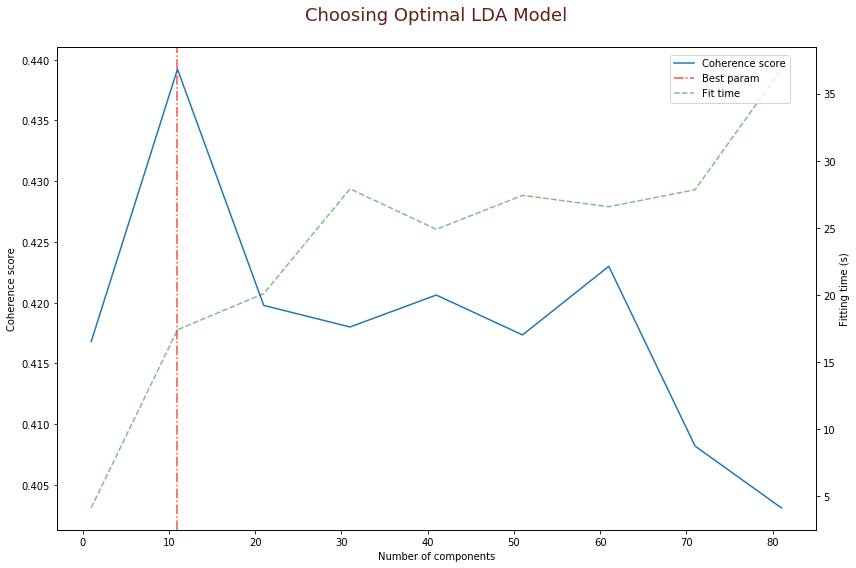

In [17]:
# Create dataframe of results
coherence_test = pd.DataFrame(coherence_test,
                              columns=["k","coherence","time"])

# Select best number of topics
best_nb_topics = coherence_test\
                    .loc[coherence_test.coherence.argmax(),"k"]

# Plot results
fig, ax1 = plt.subplots(figsize=(12,8))
x = coherence_test["k"]
y1 = coherence_test["coherence"]
y2 = coherence_test["time"]

ax1.plot(x, y1, label="Coherence score")
ax1.axvline(x=best_nb_topics, color='r', alpha=.7,
            linestyle='dashdot', label='Best param')
ax1.set_xlabel("Number of components")
ax1.set_ylabel("Coherence score")

ax2 = ax1.twinx()
ax2.plot(x, y2, label="Fit time",
         color='g', alpha=.5,
         linestyle='--')
ax2.set_ylabel("Fitting time (s)")

plt.title("Choosing Optimal LDA Model\n",
          color="#641E16", fontsize=18)
legend = fig.legend(loc=1, bbox_to_anchor=(.92, .9))

fig.tight_layout()
plt.show()

Testons à présent le modèle avec le meilleur nombre théorique de topics pour l'afficher avec LDAvis :

In [18]:
# Best LDA visualization
# Construire le modèle LDA
best_lda_model = gensim.models.ldamulticore\
                    .LdaMulticore(corpus=corpus,
                                  id2word=id2word,
                                  num_topics=best_nb_topics,
                                  random_state=8,
                                  per_word_topics=True,
                                  workers=4)
gensimvis.prepare(best_lda_model, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.019368 -0.065827       1        1  12.257745
10     0.037799  0.030219       2        1  10.830096
9     -0.044318 -0.006671       3        1  10.170311
8     -0.107792 -0.027928       4        1   9.764677
5     -0.003479 -0.001297       5        1   9.718945
2     -0.026517  0.024694       6        1   8.629729
3      0.029046  0.049898       7        1   8.241083
4     -0.041995 -0.039446       8        1   8.141719
6      0.052921  0.052605       9        1   7.647058
7     -0.020161  0.053515      10        1   7.481265
1      0.105128 -0.069762      11        1   7.117373, topic_info=        Term          Freq         Total Category  logprob  loglift
67      file  19988.000000  19988.000000  Default  30.0000  30.0000
398    image   8883.000000   8883.000000  Default  29.0000  29.0000
179    class  10538.000000  10538.000000  Default  28.0000  28.0000
106    array   5615.000000   5615.000000  Default  27.0000  27.0000
672    video   2366.000000   2366.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
319   string    544.153937   5839.192912  Topic11  -5.2058   0.2695
195   number    502.263519   4203.691116  Topic11  -5.2859   0.5180
45   problem    560.328862  13072.335669  Topic11  -5.1765  -0.5071
67      file    539.845691  19988.743313  Topic11  -5.2138  -0.9690
242   result    466.236353   4993.380706  Topic11  -5.3604   0.2715

[1026 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
3328      1  0.964460        aaa
8596     11  0.899122         ab
5383      1  0.067919  accordion
5383      5  0.022640  accordion
5383      6  0.045280  accordion
...     ...       ...        ...
2628      5  0.005930    youtube
2628      6  0.011861    youtube
2628      8  0.014826    youtube
2628      9  0.859907    youtube
2628     10  0.005930    youtube

[4295 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 11, 10, 9, 6, 3, 4, 5, 7, 8, 2])

Pour attribuer des Tags à chaque question sur ces modèles non-supervisés, nous allons créer une matrice Topic/Tags en réalisant une multiplication matricielle des matrices Document / Topic et Document / Tags.


In [19]:
# Calculate Document/topic matrix with Gensim
doc_topic = pd.DataFrame(best_lda_model\
                             .get_document_topics(corpus,
                                                  minimum_probability=0))
for topic in doc_topic.columns:
    doc_topic[topic] = doc_topic[topic].apply(lambda x : x[1])

print('document/tag : ', y_binarized.shape)
print('document/topic : ', doc_topic.shape)

document/tag :  (43288, 50)
document/topic :  (43288, 11)


In [20]:
# Print documents / topic matrix
doc_topic.head(3)

,0,1,2,3,4,5,6,7,8,9,10
0,0.001624,0.001624,0.983762,0.001624,0.001624,0.001624,0.001624,0.001624,0.001624,0.001624,0.001624
1,0.001935,0.001935,0.001935,0.001935,0.284352,0.001935,0.001935,0.001935,0.370485,0.329682,0.001935
2,0.949486,0.005052,0.005051,0.005051,0.005051,0.005051,0.005051,0.005051,0.005051,0.005051,0.005051


A présent, créons la matrice Topic / Tags grâce aux probabilités obtenues :

In [21]:
# Matricial multiplication with Document / Topics transpose
topic_tag = np.matmul(doc_topic.T, y_binarized)
topic_tag.shape

(11, 50)

In [22]:
topic_tag

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,626.149455,138.843397,52.494232,177.555082,60.815243,80.939144,262.211387,185.196241,250.096709,1227.839723,...,49.230587,32.129620,66.507384,59.180196,214.926753,57.237419,62.452347,79.344342,45.719506,44.575437
1,265.502318,27.010971,69.361996,112.641489,17.958948,67.020523,87.162203,68.243155,250.130027,608.567675,...,48.806408,23.189789,88.587021,78.734442,27.274720,22.981167,37.935805,112.506425,45.340774,26.653417
2,237.705003,51.538682,21.510087,197.592297,43.191832,28.947521,123.422271,42.188266,188.276170,486.871561,...,32.519483,21.908244,86.752611,38.544095,37.961660,99.690437,281.577666,112.711006,77.665015,50.752016
3,192.065636,22.723510,101.613836,222.527070,16.167400,93.365425,41.269764,19.149631,134.304070,337.102538,...,304.437085,144.847321,29.745865,49.908786,22.780667,25.190484,84.763845,66.608481,39.523034,84.036715
4,215.225857,87.753371,11.986887,176.316130,62.302230,15.173093,124.755364,76.368174,63.026882,375.673704,...,55.339315,37.851138,10.594971,39.010719,165.609541,74.913628,44.629415,16.345012,30.131714,21.303840
5,416.928695,56.172716,46.776850,174.777390,33.398044,39.027098,137.788772,125.186691,113.308200,801.845273,...,90.178127,61.779698,28.291596,106.516257,35.503966,103.106732,134.188216,216.815757,182.828004,47.107064
6,166.293211,60.826224,166.797801,203.159708,31.015065,369.818412,49.114187,21.970467,183.227085,368.327926,...,74.004296,28.972832,141.485386,96.047027,7.626526,13.269070,32.984251,35.507953,53.305930,23.107922
7,175.053063,49.759734,26.464732,183.487778,47.440480,25.757158,113.362731,40.182046,108.594385,355.807784,...,484.456737,324.814769,59.274212,26.773906,10.346652,47.010347,78.340387,23.830773,34.086349,32.815484
8,263.716320,200.553546,9.709267,195.027918,98.259539,9.211424,375.356008,151.400209,37.454735,527.867909,...,43.177265,46.401373,9.201900,30.768847,11.692053,48.105664,79.361601,29.991383,26.584312,28.138810
9,319.093323,104.801194,14.248876,584.522236,43.066990,27.048405,128.393692,36.944370,149.594797,576.169672,...,56.066553,65.714155,23.420215,53.372215,38.287761,77.349813,134.820977,23.703233,109.852658,291.329908


Nous obtenons donc une matrice dont les lignes représentent les Topics créés et les colonnes les Tags associés et leurs distribution. Nous allons donc créer nos prédictions en prenant les  n premiers tags associés aux topics de chaque document :

In [23]:
y_results = pd.DataFrame(y)
y_results["best_topic"] = doc_topic.idxmax(axis=1).values
y_results["nb_tags"] = y_results["Tags"].apply(lambda x : len(x))

df_y_bin = pd.DataFrame(y_binarized)
df_dict = dict(
    list(
        df_y_bin.groupby(df_y_bin.index)
    )
)

tags_num = []
for k, v in df_dict.items():
    check = v.columns[(v == 1).any()]
    tags_num.append(check.to_list())

y_results["y_true"] = tags_num
y_results.head(3)

,Tags,best_topic,nb_tags,y_true
0,"[python, multithreading]",2,2,"[27, 33]"
1,"[ruby-on-rails, angularjs]",8,2,"[4, 37]"
2,"[python, unit-testing]",0,2,"[33, 44]"


In [24]:
# Select predicted tags in Topics / Tags matrix
list_tag = []
for row in y_results.itertuples():
    nb_tags = row.nb_tags
    best_topic = row.best_topic
    row_tags = list(topic_tag.iloc[best_topic]\
                    .sort_values(ascending=False)[0:nb_tags].index)
    list_tag.append(row_tags)
    
y_results["y_pred"] = list_tag
y_results.head(3)

,Tags,best_topic,nb_tags,y_true,y_pred
0,"[python, multithreading]",2,2,"[27, 33]","[22, 9]"
1,"[ruby-on-rails, angularjs]",8,2,"[4, 37]","[22, 32]"
2,"[python, unit-testing]",0,2,"[33, 44]","[9, 10]"


Nous allons tester plusieurs métriques sur ce modèle LDA :

Accuracy score :

F1 score :

Jaccard similarity score :

Recall :

Precision :

In [25]:
def metrics_score(model, df, y_true, y_pred):
    """Compilation function of metrics specific to multi-label
    classification problems in a Pandas DataFrame.
    This dataFrame will have 1 row per metric
    and 1 column per model tested. 

    Parameters
    ----------------------------------------
    model : string
        Name of the tested model
    df : DataFrame 
        DataFrame to extend. 
        If None : Create DataFrame.
    y_true : array
        Array of true values to test
    y_pred : array
        Array of predicted values to test
    ----------------------------------------
    """
    if(df is not None):
        temp_df = df
    else:
        temp_df = pd.DataFrame(index=["Accuracy", "F1",
                                      "Jaccard", "Recall",
                                      "Precision"],
                               columns=[model])
        
    scores = []
    scores.append(metrics.accuracy_score(y_true, 
                                         y_pred))
    scores.append(metrics.f1_score(y_pred, 
                                   y_true, 
                                   average='weighted'))
    scores.append(metrics.jaccard_score(y_true, 
                                        y_pred, 
                                        average='weighted'))
    scores.append(metrics.recall_score(y_true, 
                                       y_pred, 
                                       average='weighted'))
    scores.append(metrics.precision_score(y_true, 
                                          y_pred, 
                                          average='weighted'))
    temp_df[model] = scores
    
    return temp_df

In [26]:
# Create matrix for pred and true y LDA
lda_y_pred = np.zeros(y_binarized.shape)
n = 0
for row in y_results.y_pred.values:
    for i in range(len(row)):
        lda_y_pred[n,row[i]] = 1
    n+=1
    
lda_y_true = np.zeros(y_binarized.shape)
m = 0
for row in y_results.y_true.values:
    for i in range(len(row)):
        lda_y_true[m,row[i]] = 1
    m+=1

In [27]:
df_metrics_compare = metrics_score("LDA", df=None,
                                   y_true=lda_y_true,
                                   y_pred=lda_y_pred)
df_metrics_compare

,LDA
Accuracy,0.066485
F1,0.242978
Jaccard,0.067381
Recall,0.180826
Precision,0.118191


## Modèle NMF

Nous allons donc nous baser sur les résultats de la LDA pour déterminer un nombre correct de composants. Ici, nous prendrons 11 topics pour avoir un bon compromis "temps d'entrainement" / précision et utiliserons les matrices Tfidf créées lors du preprocessing.

In [28]:
def plot_top_words(model, feature_names, 
                   n_top_words, nb_topic_plot, title):
    """Function for displaying the plots of the 
    best x words representative of the categories of NMF.

    Parameters
    ----------------------------------------
    model : NMF model
        Fitted model of NMF to plot
    feature_names : array
        Categories result of the vectorizer (TFIDF ...)
    n_top_words : int
        Number of words for each topic.
    title : string
        Title of the plot.
    ----------------------------------------
    """
    rows = int(nb_topic_plot/6)
    fig, axes = plt.subplots(rows, 6, 
                             figsize=(30, rows*10), 
                             sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        if(topic_idx < nb_topic_plot):
            top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
            top_features = [feature_names[i] for i in top_features_ind]
            weights = topic[top_features_ind]

            ax = axes[topic_idx]
            bartopic = ax.barh(top_features, weights, height=0.7)
            bartopic[0].set_color('#f48023')
            ax.set_title(f'Topic {topic_idx +1}',
                         fontdict={'fontsize': 30})
            ax.invert_yaxis()
            ax.tick_params(axis='both', which='major', labelsize=20)
            for i in 'top right left'.split():
                ax.spines[i].set_visible(False)
            fig.suptitle(title, fontsize=36, color="#641E16")

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

--------------------------------------------------
Start NMF fitting on Full_doc ...
--------------------------------------------------
End of training :
Execution time : 3.86s
--------------------------------------------------


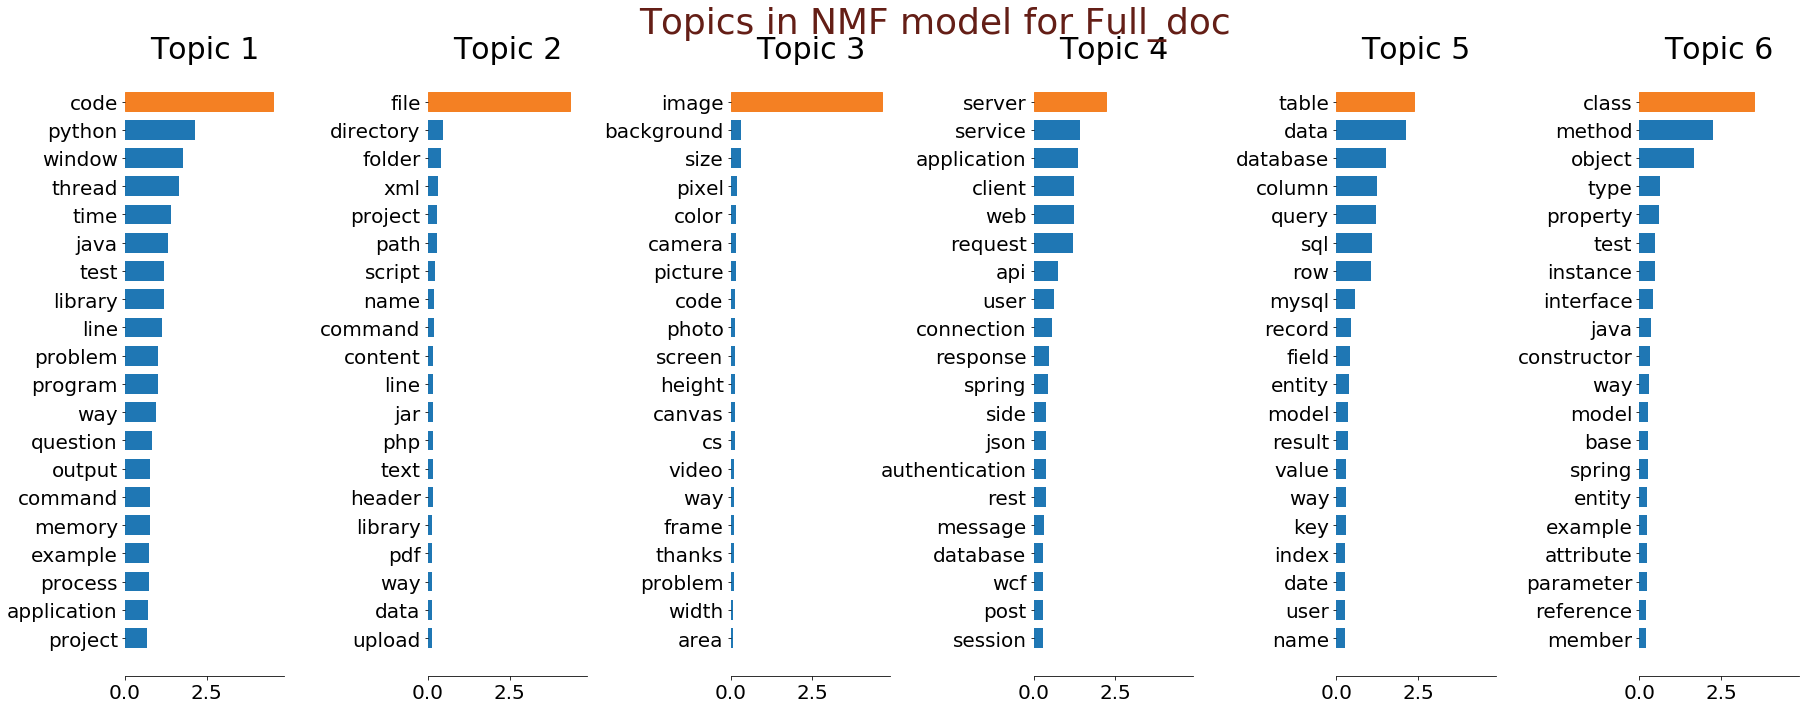

In [29]:
# Define number of topics to test
n_topics = best_nb_topics

print("-"*50)
print("Start NMF fitting on Full_doc ...")
print("-" * 50)
start_time = time.time()
# Initializing the NMF
full_nmf = NMF(n_components=n_topics,
               init='nndsvd',
               random_state=8)

# Fit NMF on Body vectorized
full_nmf.fit(X_tfidf)

exec_time = time.time() - start_time
print("End of training :")
print("Execution time : {:.2f}s".format(exec_time))
print("-" * 50)

# Plot the 6 first topics
ff_feature_names = vectorizer.get_feature_names()
plot_top_words(full_nmf, ff_feature_names, 20, 6,
               'Topics in NMF model for Full_doc')

La modélisation avec NMF nous apporte des catégories aussi lisibles que celles de l'algorithme LDA. 1 mot est toujours beaucoup plus représentaif de cette catégorie mais les regroupements sont globalement cohérents. Un topic par exemple illustre bien les sujets liés à SQL (Topic 5), aux images (Topic 3),...

En revanche, les topics générés restent très généraux et ne permettent pas une catégorisation cohérente pour notre problème d'auto-tagging. Nous allons donc tester des modèles supervisés.

# Modèles supervisés

## Régression logistique

Construire un modèle permettant de prédire / expliquer les valeurs prises par une variable cible qualitative à partir d’un ensemble de variables explicatives quantitatives ou qualitatives encodées.

Pour cette partie sur les modélisations supervisées, nous allons utiliser la variable Full_doc qui regroupe le Title et le Body puis créer un Pipeline qui ne pourra pas inclure la transformation de notre variable cible (MultiLabelBinarizer ne fonctionne pas dans les Pipeline SKlearn).

In [30]:
# Initialize Logistic Regression with OneVsRest
param_logit = {"estimator__C": [100, 10, 1.0, 0.1],
               "estimator__penalty": ["l1", "l2"],
               "estimator__dual": [False],
               "estimator__solver": ["liblinear"]}

multi_logit_cv = GridSearchCV(OneVsRestClassifier(LogisticRegression()),
                              param_grid=param_logit,
                              n_jobs=-1,
                              cv=5,
                              scoring="f1_weighted",
                              return_train_score = True,
                              refit=True)
multi_logit_cv.fit(X_train, y_train)

/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))


GridSearchCV(cv=5,
             estimator=OneVsRestClassifier(estimator=LogisticRegression()),
             n_jobs=-1,
             param_grid={'estimator__C': [100, 10, 1.0, 0.1],
                         'estimator__dual': [False],
                         'estimator__penalty': ['l1', 'l2'],
                         'estimator__solver': ['liblinear']},
             return_train_score=True, scoring='f1_weighted')

In [31]:
logit_cv_results = pd.DataFrame.from_dict(multi_logit_cv.cv_results_)
print("-"*50)
print("Best params for Logistic Regression")
print("-" * 50)
logit_best_params = multi_logit_cv.best_params_
print(logit_best_params)

--------------------------------------------------
Best params for Logistic Regression
--------------------------------------------------
{'estimator__C': 10, 'estimator__dual': False, 'estimator__penalty': 'l1', 'estimator__solver': 'liblinear'}


In [32]:
logit_cv_results[logit_cv_results["params"]==logit_best_params]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__C,param_estimator__dual,param_estimator__penalty,param_estimator__solver,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
2,60.250083,1.778809,0.135625,0.002458,10,False,l1,liblinear,"{'estimator__C': 10, 'estimator__dual': False,...",0.539477,...,0.534652,0.006657,1,0.596072,0.599982,0.599904,0.599335,0.59632,0.598322,0.001753


Nous pouvons maintenant réaliser les prédictions avec le modèle de régression logistique sur le jeu de test pour pouvoir les comparer avec le jeu y_test.

In [33]:
# Predict
y_test_predicted_labels_tfidf = multi_logit_cv.predict(X_test)

# Inverse transform
y_test_pred_inversed = multilabel_binarizer\
    .inverse_transform(y_test_predicted_labels_tfidf)
y_test_inversed = multilabel_binarizer\
    .inverse_transform(y_test)

print("-"*50)
print("Print 5 first predicted Tags vs true Tags")
print("-" * 50)
print("Predicted:", y_test_pred_inversed[0:5])
print("True:", y_test_inversed[0:5])

--------------------------------------------------
Print 5 first predicted Tags vs true Tags
--------------------------------------------------
Predicted: [(), (), ('c++',), ('ios', 'iphone', 'objective-c'), ('android',)]
True: [('c++', 'windows'), ('node.js',), ('c',), ('iphone', 'objective-c'), ('android',)]


Puis nous calculons les diverses métriques sur le meilleur modèle de régression logistique :

In [34]:
df_metrics_compare = metrics_score("Logit", 
                                   df=df_metrics_compare, 
                                   y_true = y_test,
                                   y_pred = y_test_predicted_labels_tfidf)
df_metrics_compare

,LDA,Logit
Accuracy,0.066485,0.231578
F1,0.242978,0.565543
Jaccard,0.067381,0.381523
Recall,0.180826,0.436739
Precision,0.118191,0.717523


## Modélisation avec RandomForest

In [35]:
# Initialize RandomForest with OneVsRest
param_rfc = {"estimator__max_depth": [5, 25, 50],
             "estimator__min_samples_leaf": [1, 5, 10],
             "estimator__class_weight": ["balanced"]}

multi_rfc_cv = GridSearchCV(OneVsRestClassifier(RandomForestClassifier()),
                            param_grid=param_rfc,
                            n_jobs=-1,
                            cv=2,
                            scoring="f1_weighted",
                            return_train_score = True,
                            refit=True,
                            verbose=3)
# Fit on Sample data
multi_rfc_cv.fit(X_train[0:7000], y_train[0:7000])


Fitting 2 folds for each of 9 candidates, totalling 18 fits


/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))


GridSearchCV(cv=2,
             estimator=OneVsRestClassifier(estimator=RandomForestClassifier()),
             n_jobs=-1,
             param_grid={'estimator__class_weight': ['balanced'],
                         'estimator__max_depth': [5, 25, 50],
                         'estimator__min_samples_leaf': [1, 5, 10]},
             return_train_score=True, scoring='f1_weighted', verbose=3)

In [36]:
rfc_cv_results = pd.DataFrame.from_dict(multi_rfc_cv.cv_results_)
print("-"*50)
print("Best params for RandomForestClassifier")
print("-" * 50)
rfc_best_params = multi_rfc_cv.best_params_
print(rfc_best_params)

--------------------------------------------------
Best params for RandomForestClassifier
--------------------------------------------------
{'estimator__class_weight': 'balanced', 'estimator__max_depth': 25, 'estimator__min_samples_leaf': 5}


In [37]:
rfc_best_params_ok = {}
for k, v in rfc_best_params.items():
    rfc_best_params_ok[k.replace("estimator__","")] = v

In [38]:
# Refit RandomForestClassifier best_params with full dataset
rfc_final_model = OneVsRestClassifier(RandomForestClassifier(**rfc_best_params_ok))
rfc_final_model.fit(X_train, y_train)

# Predict
y_test_predicted_labels_tfidf_rfc = rfc_final_model.predict(X_test)

# Inverse transform
y_test_pred_inversed_rfc = multilabel_binarizer\
    .inverse_transform(y_test_predicted_labels_tfidf_rfc)

print("-"*50)
print("Print 5 first predicted Tags vs true Tags")
print("-" * 50)
print("Predicted:", y_test_pred_inversed_rfc[0:5])
print("True:", y_test_inversed[0:5])

--------------------------------------------------
Print 5 first predicted Tags vs true Tags
--------------------------------------------------
Predicted: [(), ('javascript',), ('c', 'c#', 'c++'), ('cocoa-touch', 'ios', 'iphone', 'objective-c', 'swift', 'xcode'), ('android',)]
True: [('c++', 'windows'), ('node.js',), ('c',), ('iphone', 'objective-c'), ('android',)]


In [39]:
df_metrics_compare = metrics_score("RandomForest", 
                                   df=df_metrics_compare,
                                   y_true = y_test,
                                   y_pred = y_test_predicted_labels_tfidf_rfc)
df_metrics_compare

,LDA,Logit,RandomForest
Accuracy,0.066485,0.231578,0.146916
F1,0.242978,0.565543,0.557301
Jaccard,0.067381,0.381523,0.426640
Recall,0.180826,0.436739,0.701644
Precision,0.118191,0.717523,0.519836


Les métriques sur le modèle RandomForest sont moins bonnes mais semblent cependant plus cohérente avec les données, ce d'autant que les métriques Jaccard et F1 sont proches. D'autre part, nous pouvons vérifier le nombre de lignes dont les Tags ne sont pas prédit afin de voir si l'un des modèles est meilleur :

In [40]:
Tags_per_row_lr = y_test_predicted_labels_tfidf.sum(axis=1)
null_rate_lr = round(((Tags_per_row_lr.size - np.count_nonzero(Tags_per_row_lr))
                      /Tags_per_row_lr.size)*100,2)
Tags_per_row_rfc = y_test_predicted_labels_tfidf_rfc.sum(axis=1)
null_rate_rfc = round(((Tags_per_row_rfc.size - np.count_nonzero(Tags_per_row_rfc))
                       /Tags_per_row_rfc.size)*100,2)
print("-"*50)
print("Percentage of non tagged question for each model")
print("-" * 50)
print("Logistic Regression: {}%".format(null_rate_lr))
print("Random Forest: {}%".format(null_rate_rfc))


--------------------------------------------------
Percentage of non tagged question for each model
--------------------------------------------------
Logistic Regression: 31.13%
Random Forest: 5.99%


Le Random Forest semble donc plus approprié à notre programme d'auto-tagging sur les données Stackoverflow. 

Nous allons à présent tester ce modèle RandomForest avec Classifier Chains pour remplacer la méthode One versus rest

## Modèle RandomForest avec Classifier Chains

Avec la méthode ClassifierChains, chaque modèle fait une prédiction dans l'ordre spécifié en utilisant toutes les fonctionnalités disponibles fournies au modèle mais également les prédictions des modèles précédents.

In [41]:
rfc_base_model = RandomForestClassifier(**rfc_best_params_ok)
chain = ClassifierChain(rfc_base_model, order='random')
chain.fit(X_train, y_train)

ClassifierChain(base_estimator=RandomForestClassifier(class_weight='balanced',
                                                      max_depth=25,
                                                      min_samples_leaf=5),
                order='random')

In [42]:
# Predict
y_test_predicted_labels_tfidf_chain = chain.predict(X_test)

# Inverse transform
y_test_pred_inversed_chain = multilabel_binarizer\
    .inverse_transform(y_test_predicted_labels_tfidf_chain)

print("-"*50)
print("Print 5 first predicted Tags vs true Tags")
print("-" * 50)
print("Predicted:", y_test_pred_inversed_chain[0:5])
print("True:", y_test_inversed[0:5])

--------------------------------------------------
Print 5 first predicted Tags vs true Tags
--------------------------------------------------
Predicted: [('c++',), ('ajax', 'html', 'javascript', 'jquery', 'php'), ('.net', 'c#'), ('cocoa-touch', 'ios', 'iphone', 'objective-c', 'swift', 'xcode'), ('android', 'java')]
True: [('c++', 'windows'), ('node.js',), ('c',), ('iphone', 'objective-c'), ('android',)]


In [43]:
Tags_per_row_chain = y_test_predicted_labels_tfidf_chain.sum(axis=1)
null_rate_chain = round(((Tags_per_row_chain.size - np.count_nonzero(Tags_per_row_chain))
                       /Tags_per_row_chain.size)*100,2)
print("-"*50)
print("Percentage of non tagged question for chain model")
print("-" * 50)
print("RandomForest with Classifier Chains: {}%".format(null_rate_chain))

--------------------------------------------------
Percentage of non tagged question for chain model
--------------------------------------------------
RandomForest with Classifier Chains: 0.73%


In [44]:
df_metrics_compare = metrics_score("RFC Chains", 
                                   df=df_metrics_compare,
                                   y_true = y_test,
                                   y_pred = y_test_predicted_labels_tfidf_chain)
df_metrics_compare

,LDA,Logit,RandomForest,RFC Chains
Accuracy,0.066485,0.231578,0.146916,0.120351
F1,0.242978,0.565543,0.557301,0.516583
Jaccard,0.067381,0.381523,0.426640,0.394002
Recall,0.180826,0.436739,0.701644,0.702739
Precision,0.118191,0.717523,0.519836,0.477372


Le modèle RandomForest avec Classifier Chains offre des métriques similaires au modèle avec OneVsRest mais le taux de remplissage des valeurs prédites est encore meilleur.

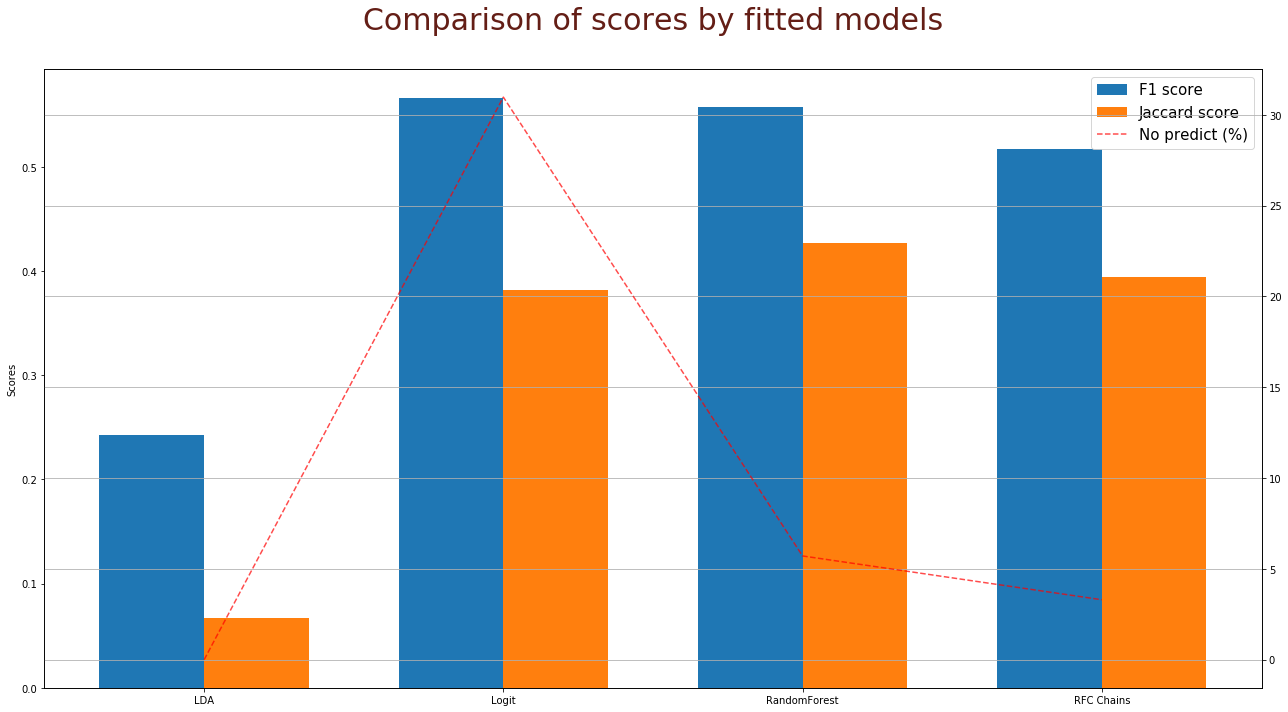

In [45]:
x = np.arange(len(df_metrics_compare.columns))
width = 0.35

fig = plt.figure(figsize=(18,10))
ax1 = fig.add_subplot(111)
f1_scores = ax1.bar(x - width/2, df_metrics_compare.iloc[1,:], width, label="F1 score")
jacc_scores = ax1.bar(x + width/2, df_metrics_compare.iloc[2,:], width, label="Jaccard score")

ax2 = ax1.twinx()
non_predict = ax2.plot(x, [0,30.97,5.71,3.3],
                       linestyle='--',
                       color="red", alpha=.7,
                       label='No predict (%)')
ax2.grid(None)

ax1.set_ylabel('Scores')
ax1.set_title('Comparison of scores by fitted models\n',
              color="#641E16", 
              fontdict={'fontsize': 30})
ax1.set_xticks(x)
ax1.set_xticklabels(df_metrics_compare.columns)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc=0,
           fontsize=15)

#ax1.bar_label(f1_scores, padding=3)
#ax1.bar_label(jacc_scores, padding=3)

fig.tight_layout()

plt.show()

On peut constater que le modèle RandomForest avec Classifier Chain offre le meilleur compromis entre le taux de valeur prédites et les métriques Jaccard, F1. 

In [46]:
# Export fitted model and Preprocessor
joblib.dump(multi_logit_cv,'logit_nlp_model.pkl')
joblib.dump(vectorizer,'tfidf_vectorizer.pkl')
joblib.dump(multilabel_binarizer,'multilabel_binarizer.pkl')

/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_hand

['multilabel_binarizer.pkl']

In [47]:
#pip install deep-translator

# Modèles supervisés Sentence Embedding

## Word2Vec

### Cleaning

In [48]:
#pip install tensorflow

In [49]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/h5py/__init__.py:36: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  from ._conv import register_converters as _register_converters
/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/h5py/__init__.py:36: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  from ._conv import register_converters as _register_converters
/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/fsspec/registry.py:59: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  minversions = {"s3fs": LooseVersion("0.3.0"), "gcsfs": LooseVersion("0.3.0")}
/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/fsspec/registry.py:59: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  minversions = {"s3fs": LooseVersion("0.3.0"), "gcsfs": LooseVersion("0.3.0")}


In [50]:
data_emb = pd.read_csv("data_emb.csv", sep=',')

In [51]:
data_emb.head()

,Title,Body,Tags,Score,ViewCount,FavoriteCount,AnswerCount,Tags_list,number_of_tags
0,PyQt - Dialog in another thread,<p>my program has a main window and in this wi...,"python,multithreading,qt,dialog,pyqt",2,6464,2,2,"['python', 'multithreading']",2
1,Action Cable and AngularJS Cross Domain Integr...,<p>I currently have a Rails 5 application acti...,"ruby-on-rails,angularjs,websocket,cross-domain...",5,1107,2,1,"['ruby-on-rails', 'angularjs']",2
2,Cannot create mockito mock with __exit__ method,<p>I am not able to attach <code>__exit__</cod...,"python,unit-testing,mockito,attributeerror,con...",1,113,1,1,"['python', 'unit-testing']",2
3,Why Integrating Spring Cloud application with ...,<p><strong>Intent</strong> : I am working on a...,"java,amazon-web-services,spring-boot,spring-cl...",2,5102,3,1,['java'],1
4,Add custom header to all Swagger responses in ...,<p>We are having WebApi server with Swagger fo...,"c#,.net,asp.net-web-api,swagger,swashbuckle",3,1463,1,1,"['c#', '.net']",2


In [66]:
tags = data_emb[['Tags']].copy()

To extract features using methods such as word2Vec, we should not remove stopwords or lemmatize as we did before, so we create a new function.

In [52]:
from bs4 import BeautifulSoup  
import re
def message_to_words(raw_title, raw_text):
   
    # 1. Join Title and Texte
    join_text = " ".join((BeautifulSoup(raw_title).get_text(),BeautifulSoup(raw_text).get_text()))
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", join_text) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    return( " ".join(words)) 

/Users/macbookpro/opt/anaconda3/lib/python3.7/site-packages/html5lib/_trie/_base.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping


In [53]:
message_to_words(data_emb["Title"][0], data_emb["Body"][0])

'pyqt dialog in another thread my program has a main window and in this window it runs a thread to read the power from a photodetector then it sends a signal which is captured by a slot in the main window that updates the main window s gui then i have another widget let s call it programming widget that pops from the main window which is basically a plain text into which the user can insert commands so the program will execute them now the issue comes when i just open the programming widget with show the main window keeps updating the photodetector however when i start executing a sequence from the programming widget the main window freezes and the photodetector readings stops with it while is executing the commands i guess it keeps reading because is in another thread but it stops updating the main window s gui my question is the programming widget is already by default in another thread since the main window keeps working when it s popped so why it main window freezes when the progra

In [54]:
# Get the number of reviews based on the dataframe column size
num_messages = data_emb["Body"].size

# Initialize an empty list to hold the clean reviews
clean_train_messages_w2v = []

# Loop over each review; create an index i that goes from 0 to the length
# of the movie review list 
for i in range( 0, num_messages ):
    # If the index is evenly divisible by 1000, print a message
    if( (i+1)%10000 == 0 ):
        print( "Review %d of %d\n" % ( i+1, num_messages ))                                                                    
    clean_train_messages_w2v.append( message_to_words(data_emb["Title"][i], data_emb["Body"][i]))

Review 10000 of 43348

Review 20000 of 43348

Review 30000 of 43348

Review 40000 of 43348



In [55]:
clean_train_messages_w2v[:1]

['pyqt dialog in another thread my program has a main window and in this window it runs a thread to read the power from a photodetector then it sends a signal which is captured by a slot in the main window that updates the main window s gui then i have another widget let s call it programming widget that pops from the main window which is basically a plain text into which the user can insert commands so the program will execute them now the issue comes when i just open the programming widget with show the main window keeps updating the photodetector however when i start executing a sequence from the programming widget the main window freezes and the photodetector readings stops with it while is executing the commands i guess it keeps reading because is in another thread but it stops updating the main window s gui my question is the programming widget is already by default in another thread since the main window keeps working when it s popped so why it main window freezes when the progr

In [56]:
sentences = [gensim.utils.simple_preprocess(text) for text in clean_train_messages_w2v]

### Setting parameters

On doit savoir le nombre maximum des mots dans sentences pour définir les paramètres

In [57]:
max_words = 0
for i in sentences:
    if len(i) > max_words:
        max_words = len(i)
print(max_words)

3702


###  Création du modèle Word2Vec

In [58]:
w2v_size=100   # The number of features at the end/vector size
w2v_window=5   # Maximum distance between the current and predicted word within a sentence
w2v_min_count=5 # Ignores all words with total frequency lower than this.
w2v_epochs=1    # Number of iterations (epochs) over the corpus.
maxlen = 3702 # adapt to length of sentences

In [59]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=1)
#                                                workers=multiprocessing.cpu_count())
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 42895
Word2Vec trained


In [60]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 150671


### Création de la matrice d'embedding

In [61]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  0.2847
Embedding matrix: (150671, 100)


### Création du modèle d'embedding

In [62]:
# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3702)]            0         
                                                                 
 embedding (Embedding)       (None, 3702, 100)         15067100  
                                                                 
 global_average_pooling1d (G  (None, 100)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 15,067,100
Trainable params: 15,067,100
Non-trainable params: 0
_________________________________________________________________


### Exécution du modèle

In [63]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

(43348, 100)

### Random Forest W2V

In [64]:
embeddings_w2v=pd.DataFrame(embeddings)

In [67]:
data_w2v = pd.concat((embeddings_w2v, tags),axis=1)

In [68]:
from sklearn import preprocessing
data_feat_w2v = data_w2v.drop(columns = ['Tags'])
scaler = preprocessing.StandardScaler()
label_encoder = preprocessing.LabelEncoder()

data_transformed_w2v = scaler.fit_transform(data_feat_w2v)

In [69]:
# Multilabel binarizer for targets
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(data_w2v['Tags'])
y_binarized_w2v = multilabel_binarizer.transform(data_w2v['Tags'])

In [70]:
# Create train and test split (20%)
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(data_transformed_w2v, y_binarized_w2v,
                                                    test_size=0.2, random_state=8)
print("X_train shape : {}".format(X_train_w2v.shape))
print("X_test shape : {}".format(X_test_w2v.shape))
print("y_train shape : {}".format(y_train_w2v.shape))
print("y_test shape : {}".format(y_test_w2v.shape))

X_train shape : (34678, 100)
X_test shape : (8670, 100)
y_train shape : (34678, 41)
y_test shape : (8670, 41)


In [71]:
rfc_final_model_w2v = OneVsRestClassifier(RandomForestClassifier(**rfc_best_params_ok))
rfc_final_model_w2v.fit(X_train_w2v,y_train_w2v)

# Predict
y_test_predicted_labels_w2v_rfc = rfc_final_model_w2v.predict(X_test_w2v)

In [72]:
df_metrics_compare = metrics_score("RandomForest_w2v", 
                                   df=df_metrics_compare,
                                   y_true = y_test_w2v,
                                   y_pred = y_test_predicted_labels_w2v_rfc)
df_metrics_compare

,LDA,Logit,RandomForest,RFC Chains,RandomForest_w2v
Accuracy,0.066485,0.231578,0.146916,0.120351,0.000923
F1,0.242978,0.565543,0.557301,0.516583,0.838749
Jaccard,0.067381,0.381523,0.426640,0.394002,0.690040
Recall,0.180826,0.436739,0.701644,0.702739,0.812018
Precision,0.118191,0.717523,0.519836,0.477372,0.775518


In [73]:
Tags_per_row_rfc_w2v = y_test_predicted_labels_w2v_rfc.sum(axis=1)

null_rate_rfc_w2v = round(((Tags_per_row_rfc_w2v.size - np.count_nonzero(Tags_per_row_rfc_w2v))
                       /Tags_per_row_rfc_w2v.size)*100,2)
print("-"*50)
print("Percentage of non tagged question for each model")
print("-" * 50)
print("Logistic Regression: {}%".format(null_rate_lr))
print("Random Forest_bow: {}%".format(null_rate_rfc))
print("Random Forest_w2v: {}%".format(null_rate_rfc_w2v))

--------------------------------------------------
Percentage of non tagged question for each model
--------------------------------------------------
Logistic Regression: 31.13%
Random Forest_bow: 5.99%
Random Forest_w2v: 0.0%


## BERT

In [75]:
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
import logging

In [76]:
#pip install transformers

In [77]:
#pip install sacremoses

In [78]:
# Bert
import os
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

For BERT and USE method, we can use the same cleaning as for word2vec

In [79]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

In [80]:
max_length = 16
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /Users/macbookpro/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-bas

In [ ]:
# Création des features
features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, clean_train_messages_w2v, 
                                                       max_length, batch_size, mode='HF')

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /Users/macbookpro/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-base-uncase

In [ ]:
features_bert.shape

### Random Forest BERT

In [ ]:
data_features_bert=pd.DataFrame(features_bert)

In [ ]:
data_bert = pd.concat((data_features_bert, tags[:43340]),axis=1)

In [ ]:
data_feat_bert = data_bert.drop(columns = ['Tags'])
scaler = preprocessing.StandardScaler()
label_encoder = preprocessing.LabelEncoder()

data_transformed_bert = scaler.fit_transform(data_feat_bert)

In [ ]:
# Multilabel binarizer for targets
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(data_bert['Tags'])
y_binarized_bert = multilabel_binarizer.transform(data_bert['Tags'])

In [ ]:
# Create train and test split (20%)
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(data_transformed_bert, y_binarized_bert,
                                                    test_size=0.2, random_state=8)
print("X_train shape : {}".format(X_train_bert.shape))
print("X_test shape : {}".format(X_test_bert.shape))
print("y_train shape : {}".format(y_train_bert.shape))
print("y_test shape : {}".format(y_test_bert.shape))

In [ ]:
rfc_final_model_bert = OneVsRestClassifier(RandomForestClassifier(**rfc_best_params_ok))
rfc_final_model_bert.fit(X_train_bert,y_train_bert)

# Predict
y_test_predicted_labels_bert_rfc = rfc_final_model_bert.predict(X_test_bert)

In [ ]:
df_metrics_compare = metrics_score("RandomForest_bert", 
                                   df=df_metrics_compare,
                                   y_true = y_test_bert,
                                   y_pred = y_test_predicted_labels_bert_rfc)
df_metrics_compare

## USE

For USE method, the steps are the same as for BERT method.

In [67]:
#pip install tensorflow_hub

In [ ]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [69]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [70]:
batch_size = 10
sentences_use = clean_train_messages_w2v.copy()

In [71]:
# Features creation

features_USE = feature_USE_fct(sentences_use, batch_size)

In [72]:
features_USE.shape

(43340, 512)

### Random Forest USE

In [ ]:
data_features_use=pd.DataFrame(features_USE)

In [ ]:
data_use = pd.concat((data_features_use, tags),axis=1)

In [ ]:
data_feat_use = data_use.drop(columns = ['Tags'])
scaler = preprocessing.StandardScaler()
label_encoder = preprocessing.LabelEncoder()

data_transformed_use = scaler.fit_transform(data_feat_use)

In [ ]:
# Multilabel binarizer for targets
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(data_use['Tags'])
y_binarized_use = multilabel_binarizer.transform(data_use['Tags'])

In [ ]:
# Create train and test split (20%)
X_train_use_1, X_test_use_1, y_train_use_1, y_test_use = train_test_split(data_transformed_use, y_binarized_use,
                                                    test_size=0.2, random_state=8)
print("X_train shape : {}".format(X_train_use.shape))
print("X_test shape : {}".format(X_test_use.shape))
print("y_train shape : {}".format(y_train_use.shape))
print("y_test shape : {}".format(y_test_use.shape))

In [ ]:
# Remove inf values
X_train_use_1[~np.isfinite(X_train_use_1)] = 0
y_train_use_1[~np.isfinite(y_train_use_1)] = 0
X_test_use_1[~np.isfinite(X_test_use_1)] = 0
#X_train_use_1 = np.nan_to_num(X_train_use)

In [ ]:
rfc_final_model_use = OneVsRestClassifier(RandomForestClassifier(**rfc_best_params_ok))
rfc_final_model_use.fit(X_train_use_1,y_train_use_1)

# Predict
y_test_predicted_labels_use_rfc = rfc_final_model_use.predict(X_test_use_1)

In [ ]:
df_metrics_compare = metrics_score("RandomForest_use", 
                                   df=df_metrics_compare,
                                   y_true = y_test_use_1,
                                   y_pred = y_test_predicted_labels_use_rfc)
df_metrics_compare